# ResNet Architecture

Resnet architecture is supposed to be the backbone of our SimCLR and MoCo models

Building basic resnet from scratch
Taken from - https://www.kaggle.com/code/shakhrulsiam/implementing-resnet-in-pytorch-from-scratch

A residual network, also known as ResNet, is a deep neural network architecture that introduced the concept of residual blocks.The key idea behind ResNet is the use of residual blocks, which enable the training of extremely deep networks. Traditional deep neural networks suffer from the problem of vanishing gradients, where the gradients become increasingly small as they propagate backward through multiple layers. This makes it difficult to train very deep networks because the earlier layers receive weak gradients and have trouble learning meaningful representations.

To address this issue, ResNet introduces residual connections, also called skip connections, that allow for the direct flow of information from earlier layers to later layers. Instead of trying to learn the direct mapping from the input to the output, ResNet learns the residual mapping—the difference between the input and output—making it easier for the network to optimize and learn the underlying features.

In [ ]:
# Importing necessary libraries
import torch # pretty much all we need
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# check if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

## Basic Block

A basic ResNet block is composed by two layers of 3x3 conv/batchnorm/relu. In the picture, the lines represent the residual operation.
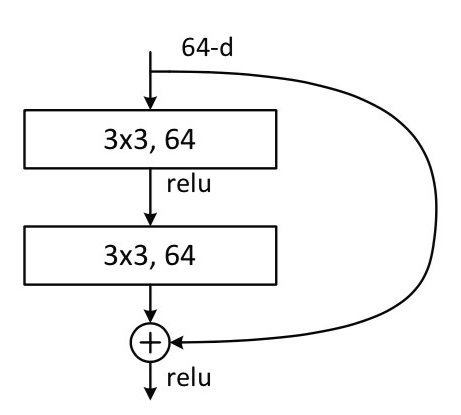

In [ ]:
# defining the basic block 
class BasicBlock(nn.Module):
    expansion = 1 # for basic block expansion is 1, for bottleneck it is 4
    # what does it mean? 
    # It means that the output channels of the block will be the same as the input channels for the basic block.
    # For the bottleneck block, the output channels will be 4 times the input channels. 
    # Resnet 18 and 34 use basic block, while Resnet 50, 101 and 152 use bottleneck block.

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

## BottleNeck Block

To increase the network depth while keeping the parameters size as low as possible, the authors defined a BottleNeck block that “The three layers are 1x1, 3x3, and 1x1 convolutions, where the 1×1 layers are responsible for reducing and then increasing (restoring) dimensions, leaving the 3×3 layer a bottleneck with smaller input/output dimensions.”
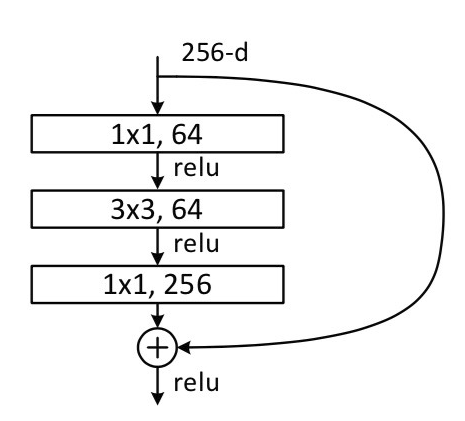


In [ ]:
class Bottleneck(nn.Module):
    expansion = 4 # for basic block expansion is 1, for bottleneck it is 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

## ResNet Layer
A ResNet’s layer is composed of the same blocks stacked one after the other.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out

## Model Architectures

In [ ]:
def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    # There are 4 layers in resnet18, each layer has 2 basic blocks, each block has 2 conv layers

def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    # There are 4 layers in resnet34, with 3, 4, 6, and 3 basic blocks respectively, each block has 2 conv layers

def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    # There are 4 layers in resnet50, with 3, 4, 6, and 3 bottleneck blocks respectively, each block has 3 conv layers

def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    # There are 4 layers in resnet101, with 3, 4, 23, and 3 bottleneck blocks respectively, each block has 3 conv layers

In [ ]:
model_dict = {
    'resnet18': [resnet18, 512],
    'resnet34': [resnet34, 512],
    'resnet50': [resnet50, 2048],
    'resnet101': [resnet101, 2048],
}

: 

In [ ]:
class ResNetModel(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet18', head='mlp', feat_dim=128):
        super(ResNetModel, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear': # linear projection head, basically map the features to feat_dim directly
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp': # 2-layer MLP with ReLU non-linearity, maps features to feat_dim, basically mapping to a vector space using 2 layers
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        elif head == 'classification': # Classification head
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim) # (feat_dim) classes for classification
            )

        # We can add more projection heads here if needed
        # Like an identity head that does nothing, for simCLR , classification head can be mounted here
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

In [ ]:
# Now, training an actual model.
# let us take a simple example of training on CIFAR-10 dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:
# Need to upscale the images to (224, 224) for resnet
# We can do this using transforms.Resize in the transform argument of the dataset
new_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
cifar10 = datasets.CIFAR10(root='./Data/CIFAR10', train=True, download=True, transform=new_transform)
# Important to transform the data to tensor, else it will throw an error
cifar10_loader = DataLoader(cifar10, batch_size=8, shuffle=True)

In [ ]:
# How many images in cifar10?
print(f'Total images in CIFAR-10 training set: {len(cifar10)}')

In [ ]:
# What are the classes in cifar10?
print(f'Classes in CIFAR-10: {cifar10.classes}')

In [ ]:
# What is the shape of one image?
image, label = cifar10[0]
print(f'Shape of one image: {image.shape}, Label: {label}')
# small images of size (3, 32, 32)
# We have resized them to (3, 224, 224) using transforms.Resize

In [ ]:
# Divide the images into train and test sets
train_size = int(0.8 * len(cifar10))
test_size = len(cifar10) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(cifar10, [train_size, test_size])

In [ ]:
print(len(train_dataset), len(test_dataset))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
model = ResNetModel(name='resnet18', head='classification', feat_dim=10).to(device) # 10 classes in cifar10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)

In [ ]:
# The actual training loop
num_epochs = 5
accumulation_steps = 2  # Number of mini-batches to accumulate gradients over
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)   # move inputs to GPU
        labels = labels.to(device)   # move labels to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps  # Scale the loss by accumulation steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}")

# I dont know why, but it is taking too long to train on my system.

In [ ]:
# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')